# The Joy of Neural Painting (4/4)
# Let's Paint!

[Neural Painters](https://arxiv.org/abs/1904.08410) [1] are a class of models that can be seen as a fully differentiable simulation of a particular non-differentiable painting program, in other words, the machine "paints" by successively generating brushstrokes (i.e., actions that defines a brushstrokes) and applying them on a canvas, as an artist would do.

This notebook is part of our Neural Painter implementation. It implements the Intrinsic Style Transfer approach introduced in [1] using a the Feature Loss introduced in [Fast.ai's MOOC](https://course.fast.ai/videos/?lesson=7). 

---

[1] *Neural Painters: A Learned Differentiable Constraint for Generating Brushstroke Paintings*. Reiichiro Nakano. arXiv preprint [arXiv:1904.08410](https://arxiv.org/abs/1904.08410), 2019.

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as VF
import torch.optim as optim
import fastai
import numpy as np
import matplotlib.pyplot as plt
import time
import json
import PIL
import os

from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
from glob import glob
from torchvision import models
from pathlib import Path
from IPython.display import display, clear_output, HTML

# from fastai.vision import *
from fastai.torch_core import requires_grad, children
from fastai.vision.gan import basic_generator, gan_critic
from fastai.callbacks import hook_outputs

from base64 import b64encode

print('torch.__version__', torch.__version__)


torch.__version__ 1.1.0


# Building Blocks

In [0]:
# A class to encapsulate some parameters
class Params():
    def __init__(self):
        super()

params = Params()
params.condition_dim = 12
params.noise_dim = 0
params.image_size = 64
params.channels = 3
params.batch_size = 128
params.lr = 0.01
params.train_epochs = 1000
params.fc_dim = int(params.image_size * params.image_size)
# Number of brushstrokes to use in the painting:
params.num_strokes = 32

## The Generator at the core of our Neural Painter

In [0]:
class GeneratorX(nn.Module):

    def __init__(self, condition_dim, fc_dim, in_size, n_channels, n_extra_layers):
        super(GeneratorX, self).__init__()
        self.fc = nn.Linear(condition_dim, fc_dim)
        self.generator = basic_generator(in_size=in_size, n_channels=n_channels, n_extra_layers=n_extra_layers, noise_sz=fc_dim)

    def forward(self, x):
        x = self.fc(x)
        x = self.generator(x.view(x.size(0), x.size(1), 1, 1))
        return x



In [4]:
generator = GeneratorX(condition_dim=params.condition_dim,
                fc_dim=params.fc_dim,
                in_size=params.image_size,
                n_channels=params.channels,
                n_extra_layers=1
               )

generator

GeneratorX(
  (fc): Linear(in_features=12, out_features=4096, bias=True)
  (generator): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(4096, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): ReLU(inplace)
      (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU(inplace)
      (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU(inplace)
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU(inplace)
      (2): BatchNorm2d(64, eps=1e-05, 

## The Feature loss for the Instrinsic Style Transfer

In [5]:
vgg_m = models.vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 553507836/553507836 [00:05<00:00, 105582457.85it/s]


[5, 12, 22, 32, 42]

In [0]:
def gram_matrix(x):
    (b, ch, h, w) = x.size()
    features = x.view(b, ch, w * h)
    features_t = features.transpose(1, 2)
    gram = features @ features_t / (ch * h * w)
    return gram
  

In [0]:
class FeatureLoss(nn.Module):
    def __init__(self, feature_extractor, layer_ids, layer_wgts, only_perceptual_loss=False):
        super(FeatureLoss, self).__init__()
        self.base_loss = torch.nn.functional.mse_loss
        self.feature_extractor = feature_extractor
        self.loss_features = [self.feature_extractor[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.only_perceptual_loss = only_perceptual_loss
        if self.only_perceptual_loss:
          self.metric_names = [f'feat_{i}' for i in range(len(layer_ids))] + [f'gram_{i}' for i in range(len(layer_ids))]
        else:
          self.metric_names = [f'feat_{i}' for i in range(len(layer_ids))] + [f'gram_{i}' for i in range(len(layer_ids))] + ['pixel',]

    def make_features(self, x, clone=False):
        self.feature_extractor(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        input_features = self.make_features(input)
        target_features = self.make_features(target, clone=True)
        
        self.feat_losses = []
        self.feat_losses += [self.base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(input_features, target_features, self.wgts)]
        self.feat_losses += [self.base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                               for f_in, f_out, w in zip(input_features, target_features, self.wgts)]
        if not self.only_perceptual_loss:
          self.feat_losses += [self.base_loss(input,target)]
          
        
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [0]:
feature_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

Let's load the `Generator` parameters. 

In [9]:
# Download our pre-trained `Generator` in case you don't have yours at hand:
! pip install gdown
! mkdir models; cd models; gdown https://drive.google.com/uc?id=1JGwvOAiDs9Pe0Fv4VQe06am5g9UR7RRy
! ls models

Downloading...
From: https://drive.google.com/uc?id=1JGwvOAiDs9Pe0Fv4VQe06am5g9UR7RRy
To: /content/models/neuro_painter_x_final_GAN_generator_param.pth
146MB [00:03, 38.5MB/s]
neuro_painter_x_final_GAN_generator_param.pth


In [0]:
# Freezing the Generator since we won't update its model parameters

generator.load_state_dict(torch.load("models/neuro_painter_x_final_GAN_generator_param.pth"))
# freeze parameters since we do not update the Generator's weights
for param in generator.parameters():
    generator.requires_grad = False
generator.cuda().eval();

In [0]:
def load_image(filename, size=None, scale=None):
  # Load an image from a given file name
    img = PIL.Image.open(filename).convert("RGB")
    if size is not None:
        img.thumbnail((size, size), PIL.Image.ANTIALIAS)
    elif scale is not None:
        size = img.size[0] * scale
        img.thumbnail((size, size), PIL.Image.ANTIALIAS)
    return img

In [13]:
# Sample content image:
! mkdir images; cd images; wget -c https://raw.githubusercontent.com/libreai/neural-painter-x/master/images/alaska_landscape.jpg

--2019-09-13 22:23:47--  https://raw.githubusercontent.com/libreai/neural-painter-x/master/images/alaska_landscape.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 104856 (102K) [image/jpeg]
Saving to: ‘alaska_landscape.jpg’

alaska_landscape.jp 100%[===================>] 102.40K  --.-KB/s    in 0.04s   

2019-09-13 22:23:48 (2.72 MB/s) - ‘alaska_landscape.jpg’ saved [104856/104856]



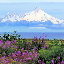

(64, 64)

In [14]:
# load the content image:

filename = 'images/alaska_landscape.jpg'
size = 64
base_image_pil = load_image(filename, size=400)
base_image_pil = transforms.CenterCrop(256)(base_image_pil).resize((size, size))
display(base_image_pil)
base_image_pil.size

In [15]:
# moving contant image to GPU
base_image = VF.to_tensor(base_image_pil).cuda()
base_image.shape

torch.Size([3, 64, 64])

In [0]:
def paint_canvas(generated_strokes, size, darkness=1):
    canvas = torch.ones_like(generated_strokes[0], requires_grad=True, dtype=torch.float32)
    
    for idx, stroke in enumerate(generated_strokes):
        # extract the stroke's darkest dominant (rgb) color
        brush_color = stroke.min(1)[0].min(1)[0].clamp_(0, 1).view(-1, 3, 1, 1)
        brush_color = brush_color.expand(-1, 3, size, size)

        # Get the "darkness" of each individual pixel in a stroke by averaging.
        darkness_mask = torch.mean(stroke, 0)

        # Make the value of a darker stroke higher.
        darkness_mask = 1 - torch.reshape(darkness_mask, (-1, 1, size, size))

        # Scale this darkness mask from 0 to 1.
        darkness_mask = darkness_mask / torch.max(darkness_mask)

        # Replace the original stroke with one that has all colored pixels set to the
        # actual color used.
        stroke_whitespace = torch.eq(stroke, 1.)

        #maxed_stroke = torch.where(stroke_whitespace, stroke, brush_color)
        maxed_stroke = torch.where(stroke_whitespace, stroke, brush_color)

        # Linearly blend
        maxed_stroke = maxed_stroke.cuda()
        darkness_mask = (darkness * darkness_mask).cuda()
        canvas = (darkness_mask) * maxed_stroke + (1-darkness_mask) * canvas

    return canvas

def paintx(generated_strokes):
    canvas = paint_canvas(generated_strokes, size=generated_strokes[0].shape[-1]).squeeze()
    
    return canvas.view(1, *canvas.shape)
    

In [48]:
# The conditions (e.g., actions for brushstrokes) to optimize using RMSprop

conditions = torch.empty((params.num_strokes, params.condition_dim)).uniform_(0, 1).cuda().requires_grad_()
print('conditions.shape', conditions.shape)

optimizer = optim.RMSprop([conditions], lr=params.lr)

conditions.shape torch.Size([32, 12])


### Let's Paint: *Intrinsic Style Transfer*. Optimize the Input Actions (brushstrokes) with the Generator frozen.

epoch 0/1000; loss: 0.48333245515823364


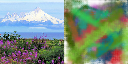

---
epoch 100/1000; loss: 0.20167626440525055


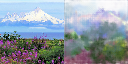

---
epoch 200/1000; loss: 0.1735667735338211


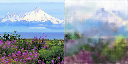

---
epoch 300/1000; loss: 0.15709562599658966


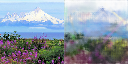

---
epoch 400/1000; loss: 0.1466209590435028


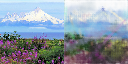

---
epoch 500/1000; loss: 0.1396922916173935


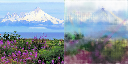

---
epoch 600/1000; loss: 0.13497959077358246


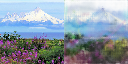

---
epoch 700/1000; loss: 0.13134512305259705


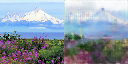

---
epoch 800/1000; loss: 0.12862445414066315


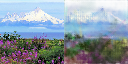

---
epoch 900/1000; loss: 0.12642326951026917


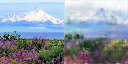

---
--- final ---


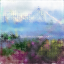

loss = 0.12473081052303314


In [49]:
losses = []

channels = 3

# -----------------
#  Train 
# -----------------
    
for epoch in range(params.train_epochs):
    def closure():
      global conditions

      conditions.data.clamp_(0, 1)

      optimizer.zero_grad()

      num_strokes, condition_dim = conditions.shape

      strokes = generator(conditions.view(num_strokes, condition_dim))
      
      canvas = paintx(strokes)

      the_loss = feature_loss(canvas, base_image.view(1, *base_image.shape))

      the_loss.backward()

      losses.append(the_loss.item())

      if epoch % 100 == 0:
          print('epoch {}/{}; loss: {}'.format(epoch, params.train_epochs, torch.mean(torch.tensor(losses)).item()))
          
          img = paintx(strokes).squeeze().cpu()
          
          display(VF.to_pil_image(torch.cat((base_image.clone().cpu(),
                                             F.interpolate(img.view(1, *img.shape) , size=(64, 64), mode='bilinear', align_corners=False).squeeze()
                                            )
                                            , dim=2)
                                 )
                 )

          print('---')
      
      return the_loss.item()
      
    optimizer.step(closure)
        
        

# a last correction...
conditions.data.clamp_(0, 1)
num_strokes, condition_dim = conditions.shape
strokes = generator(conditions.view(num_strokes, condition_dim))

print('--- final ---')

img = paintx(strokes).squeeze().cpu()
display(VF.to_pil_image(img))   

print('loss =', torch.mean(torch.tensor(losses)).item())

In [0]:
def paint_stroke_by_stroke(condition, size=64, darkness=1):
    frames = []
    
    generated_strokes = generator(condition)
    
    canvas = torch.ones_like(generated_strokes[0], requires_grad=True, dtype=torch.float32)
    
    for stroke in generated_strokes:
        # extract the stroke's darkest dominant (rgb) color
        brush_color = stroke.min(1)[0].min(1)[0].clamp_(0, 1).view(-1, 3, 1, 1)
        brush_color = brush_color.expand(-1, 3, size, size)

        # Get the "darkness" of each individual pixel in a stroke by averaging.
        darkness_mask = torch.mean(stroke, 0)

        # Make the value of a darker stroke higher.
        darkness_mask = 1 - torch.reshape(darkness_mask, (-1, 1, size, size))

        # Scale this darkness mask from 0 to 1.
        darkness_mask = darkness_mask / torch.max(darkness_mask)

        # Replace the original stroke with one that has all colored pixels set to the
        # actual color used.
        stroke_whitespace = torch.eq(stroke, 1.)

        #maxed_stroke = torch.where(stroke_whitespace, stroke, brush_color)
        maxed_stroke = torch.where(stroke_whitespace, stroke, brush_color)

        # Linearly blend
        maxed_stroke = maxed_stroke.cuda()
        darkness_mask = (darkness * darkness_mask).cuda()
        canvas = (darkness_mask) * maxed_stroke + (1-darkness_mask) * canvas
        
        img_result = VF.to_pil_image(canvas.clone().cpu().squeeze())
        frames.append(img_result)

    return frames

### Painting brushstroke by brushstroke

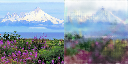

In [50]:
frames = paint_stroke_by_stroke(conditions)

for frame in frames:
    imagex = VF.to_pil_image(torch.cat((base_image.clone().cpu(), VF.to_tensor(frame)), dim=2))
    display(imagex)
    time.sleep(0.5)
    clear_output(wait=True)

In [0]:
# generating images for input frames
for idx, frame in enumerate(frames):
    imagex = VF.to_pil_image(torch.cat((base_image.clone().cpu(), VF.to_tensor(frame)), dim=2))
    imagex.save('images/alaska_{:03d}.png'.format(idx))

In [0]:
! ffmpeg -loglevel panic -y -framerate 8 -i images/alaska_%03d.png -s:v 1024x512 -c:v libx264 -profile:v high -crf 20 -pix_fmt yuv420p alaska.mp4

In [53]:
mp4 = open('alaska.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=800 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

# ~ fin ~